<a href="https://colab.research.google.com/github/mzagari/ADS504_Team_8/blob/main/Saturday_Version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nepal Earthquake - Structural Risk Prediction
__Martin Zagari, Summer Purcschke, and Dave Friesen - ADS-504-01-SU22__

In [788]:
__author__ = 'Martin Zagari, Summer Purschke, Dave Friesen'
__email__ = 'mzagari@sandiego.edu, spurschke@sandiego.edu, dfriesen@sandiego.edu'
__version__ = '1.0'
__date__ = 'August 2022'
__license__ = 'MIT'

# Setup

In [789]:
# Basics
import numpy as np
import pandas as pd
from pandas.core.arrays import numeric
import scipy.stats as ss
from scipy.stats import chi2_contingency

# Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Modeling
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc

# Utilities
import joblib
import re
from time import time
import warnings
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
#warnings.resetwarnings()
from IPython.core.pylabtools import figsize
import itertools

# Set basic options for consistent output
PRECISION = 2
np.set_printoptions(precision = PRECISION)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.precision', PRECISION)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')

# Set Matplotlib defaults for consistent visualization look 'n' feel
FONTSIZE_S = 10
FONTSIZE_M = 12
FONTSIZE_L = 14
plt.style.use('default')
plt.rcParams['figure.titlesize'] = FONTSIZE_L
plt.rcParams['figure.figsize'] = (9, 9 / (16 / 9))
plt.rcParams['figure.subplot.left'] = '0.1'
plt.rcParams['figure.subplot.bottom'] = '0.1'
plt.rcParams['figure.subplot.top'] = '0.9'
plt.rcParams['figure.subplot.wspace'] = '0.4'
plt.rcParams['lines.linewidth'] = '2'
plt.rcParams['axes.linewidth'] = '2'
plt.rcParams['axes.titlesize'] = '8'
#plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = FONTSIZE_M
plt.rcParams['xtick.labelsize'] = FONTSIZE_S
plt.rcParams['ytick.labelsize'] = FONTSIZE_S
plt.rcParams['grid.linewidth'] = '1'
plt.rcParams['legend.fontsize'] = FONTSIZE_S
plt.rcParams['legend.title_fontsize'] = FONTSIZE_S

In [790]:
%%capture

# Primary: Google Colab
#from google.colab import drive
#drive.mount('/content/drive', force_remount = True)
#%cd '/content/drive/My Drive/ads504/data'
#%cd '/content/drive//MyDrive/ADS504'

# Secondary: "If"/as needed - local working directory
%cd '/Users/davidfriesen/Desktop/OneDrive/projects/ADS504_Team_8/data'

# Load and Validate Data

In [791]:
# Set row count control totals
structure_ctrl = sum(1 for line in open('csv_building_structure.csv'))
ownership_ctrl = sum(1 for line in open('csv_building_ownership_and_use.csv'))
damage_ctrl = sum(1 for line in open('csv_building_damage_assessment_featex.csv'))

# Read files, accomodating any 'bad' rows
structure_df = pd.read_csv('csv_building_structure.csv', on_bad_lines = 'skip', low_memory = False)
ownership_df = pd.read_csv('csv_building_ownership_and_use.csv', on_bad_lines = 'skip', low_memory = False)
damage_df = pd.read_csv('csv_building_damage_assessment_featex.csv', on_bad_lines = 'skip', low_memory = False)

# Confirm load counts
print('Structure: file=%0d, import=%0d, delta=%0d' %
      (structure_ctrl, len(structure_df), structure_ctrl - len(structure_df)))
print('Ownership: file=%0d, import=%0d, delta=%0d' %
      (ownership_ctrl, len(ownership_df), ownership_ctrl - len(ownership_df)))
print('Damage: file=%0d, import=%0d, delta=%0d' %
      (damage_ctrl, len(damage_df), damage_ctrl - len(damage_df)))

Structure: file=762106, import=762105, delta=1
Ownership: file=762106, import=762105, delta=1
Damage: file=762106, import=762105, delta=1


In [792]:
structure_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762105 entries, 0 to 762104
Data columns (total 31 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             762105 non-null  float64
 1   district_id                             762105 non-null  int64  
 2   vdcmun_id                               762105 non-null  int64  
 3   ward_id                                 762105 non-null  int64  
 4   count_floors_pre_eq                     762105 non-null  int64  
 5   count_floors_post_eq                    762105 non-null  int64  
 6   age_building                            762105 non-null  int64  
 7   plinth_area_sq_ft                       762105 non-null  int64  
 8   height_ft_pre_eq                        762105 non-null  int64  
 9   height_ft_post_eq                       762105 non-null  int64  
 10  land_surface_condition                  7621

In [793]:
ownership_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762105 entries, 0 to 762104
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   building_id                    762105 non-null  float64
 1   district_id                    762105 non-null  int64  
 2   vdcmun_id                      762105 non-null  int64  
 3   ward_id                        762105 non-null  int64  
 4   legal_ownership_status         762105 non-null  object 
 5   count_families                 762103 non-null  float64
 6   has_secondary_use              762095 non-null  float64
 7   has_secondary_use_agriculture  762105 non-null  int64  
 8   has_secondary_use_hotel        762105 non-null  int64  
 9   has_secondary_use_rental       762105 non-null  int64  
 10  has_secondary_use_institution  762105 non-null  int64  
 11  has_secondary_use_school       762105 non-null  int64  
 12  has_secondary_use_industry    

In [794]:
damage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762105 entries, 0 to 762104
Data columns (total 17 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   building_id                            762105 non-null  float64
 1   district_id                            762105 non-null  int64  
 2   vdcmun_id                              762105 non-null  int64  
 3   ward_id                                762105 non-null  int64  
 4   damage_overall_collapse                500743 non-null  object 
 5   damage_overall_leaning                 500742 non-null  object 
 6   area_assesed                           762093 non-null  object 
 7   damage_grade                           762093 non-null  object 
 8   technical_solution_proposed            762093 non-null  object 
 9   has_geotechnical_risk                  762093 non-null  float64
 10  has_geotechnical_risk_land_settlement  762105 non-null  

# Build the primary working df for processing: 'building_df'

In [795]:
#binary_class = False
#trinary_class = False
#quintary_class = True

# Eliminate features considered n/a to problem statement and hypothesis, or contaminated by post-earthquake data
structure_dr = structure_df.drop(columns = ['vdcmun_id', 'ward_id',
                                            'height_ft_post_eq', 'condition_post_eq', 'technical_solution_proposed'])

##################Drop Addl Cols with Post Earthquake Contamination
structure_dr = structure_dr.drop(columns = ['count_floors_post_eq'])
##################

ownership_dr = ownership_df.drop(columns = ['district_id', 'vdcmun_id', 'ward_id']
)
damage_dr = damage_df.drop(columns=['district_id', 'vdcmun_id', 'ward_id', 'damage_grade'])

##################Drop Addl Cols with Post Earthquake Contamination
damage_dr = damage_dr.drop(columns=['area_assesed','damage_overall_collapse','damage_overall_leaning','technical_solution_proposed'])
##################

#Convert damage_grade to a numeric variable and map to number of classes:

#if binary_class is True:
#  print("2")
#  dict = {'Grade 1' : 0,
#          'Grade 2' : 0,
#          'Grade 3' : 0,
#          'Grade 4' : 1,
#          'Grade 5' : 1
#          }

#if trinary_class is True:
#  print("3")
#  dict = {'Grade 1' : 0,
#          'Grade 2' : 0,
#          'Grade 3' : 0,
#          'Grade 4' : 1,
#          'Grade 5' : 2
#          }

#if quintary_class is True:
#  print("5")
#  dict = {'Grade 1' : 1,
#          'Grade 2' : 2,
#          'Grade 3' : 3,
#          'Grade 4' : 4,
#          'Grade 5' : 5
#          }
  
# Merge all three dataframes into common set of label and prospective features
temp_df = pd.merge(structure_dr, ownership_dr, how = 'inner', on = 'building_id')
building_df = pd.merge(temp_df, damage_dr, how = 'inner', on = 'building_id')
building_df.drop('building_id', axis = 1, inplace = True)
building_df.info()

# Remap the values of the dataframe
#building_df = building_df.replace({'damage_grade': dict})
#building_df['damage_grade'] = pd.to_numeric(building_df['damage_grade'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 762104 entries, 0 to 762103
Data columns (total 45 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   district_id                             762104 non-null  int64  
 1   count_floors_pre_eq                     762104 non-null  int64  
 2   age_building                            762104 non-null  int64  
 3   plinth_area_sq_ft                       762104 non-null  int64  
 4   height_ft_pre_eq                        762104 non-null  int64  
 5   land_surface_condition                  762104 non-null  object 
 6   foundation_type                         762104 non-null  object 
 7   roof_type                               762104 non-null  object 
 8   ground_floor_type                       762104 non-null  object 
 9   other_floor_type                        762104 non-null  object 
 10  position                                7621

In [796]:
#building_df10 = building_df.sample(frac=.1, random_state=42)
#sns.pairplot(building_df10, hue = "damage_grade", corner = True, diag_kind = 'hist')  # Based on looking at the data, plot feature separation

In [797]:
building_df['damage_grade'].value_counts()

Grade 5    275764
Grade 4    183844
Grade 3    136412
Grade 2     87257
Grade 1     78815
Name: damage_grade, dtype: int64

In [798]:
# Identify prospective feature columns by 'type'
num_cols = [
    'count_floors_pre_eq',
    'age_building',
    'plinth_area_sq_ft',
    'height_ft_pre_eq',
    'count_families',
#    'damage_grade'
    ]                       #6         
cat_cols = [
    'land_surface_condition',
    'foundation_type',
    'roof_type',
    'ground_floor_type',
    'other_floor_type',
    'position',
    'plan_configuration',
    'legal_ownership_status',
    'district_id'
    ]                           #9
bin_cols = [
    'has_superstructure_adobe_mud',
    'has_superstructure_mud_mortar_stone',
    'has_superstructure_stone_flag',
    'has_superstructure_cement_mortar_stone',
    'has_superstructure_mud_mortar_brick',
    'has_superstructure_cement_mortar_brick',
    'has_superstructure_timber',
    'has_superstructure_bamboo',
    'has_superstructure_rc_non_engineered',
    'has_superstructure_rc_engineered',
    'has_superstructure_other',
    'has_secondary_use',
    'has_secondary_use_agriculture',
    'has_secondary_use_hotel',
    'has_secondary_use_rental',
    'has_secondary_use_institution',
    'has_secondary_use_school',
    'has_secondary_use_industry',
    'has_secondary_use_health_post',
    'has_secondary_use_gov_office',
    'has_secondary_use_use_police',
    'has_secondary_use_other',
    'has_geotechnical_risk',
    'has_geotechnical_risk_land_settlement',
    'has_geotechnical_risk_fault_crack',
    'has_geotechnical_risk_liquefaction',
    'has_geotechnical_risk_landslide',
    'has_geotechnical_risk_rock_fall',
    'has_geotechnical_risk_flood',
    'has_geotechnical_risk_other'
    ]                                   #30 (11, 11, 8 )

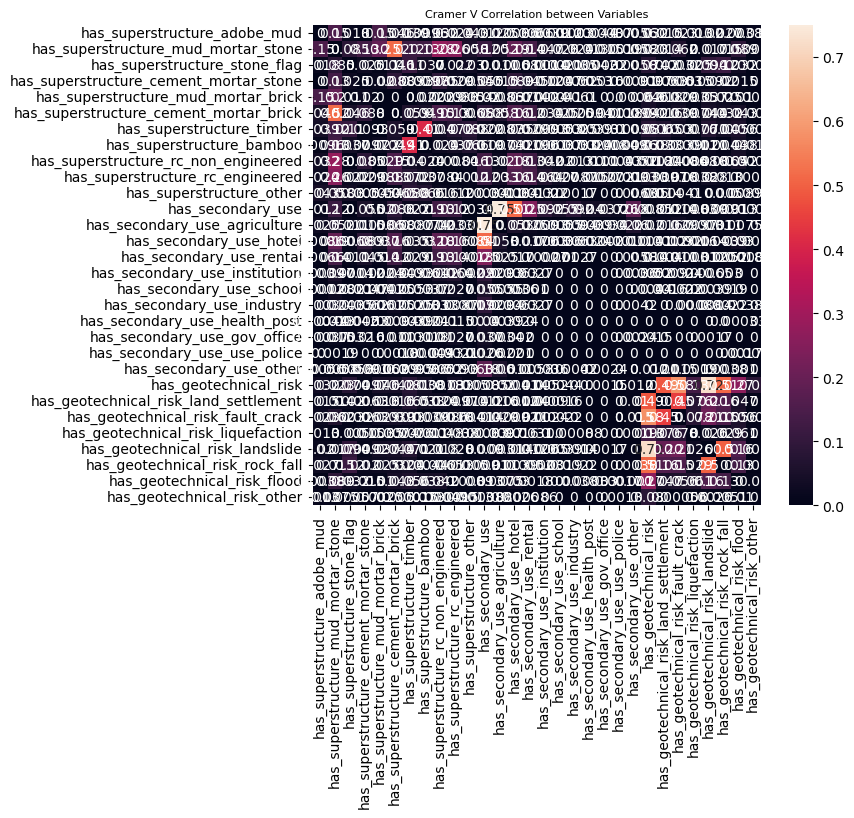

In [799]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

cols = bin_cols
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(building_df[col1], building_df[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");

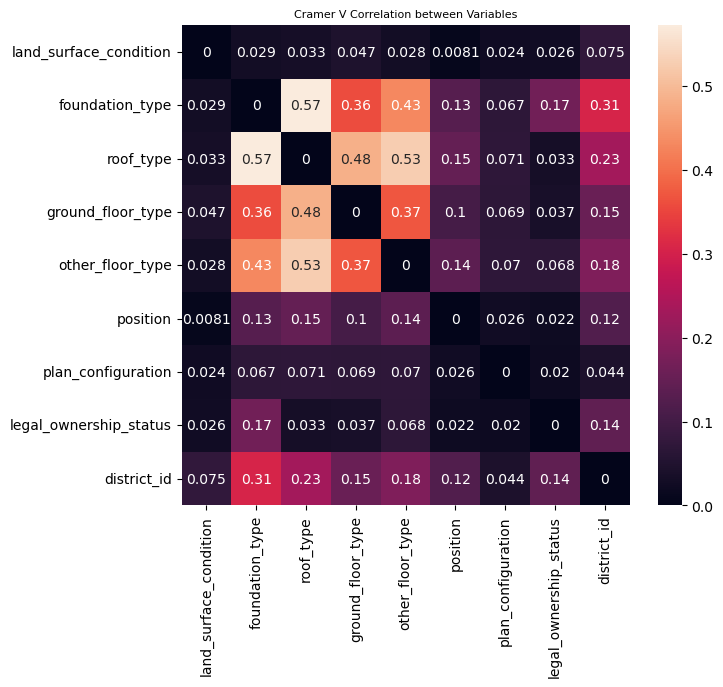

In [800]:
cols = cat_cols
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(building_df[col1], building_df[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");

#Numerical Features

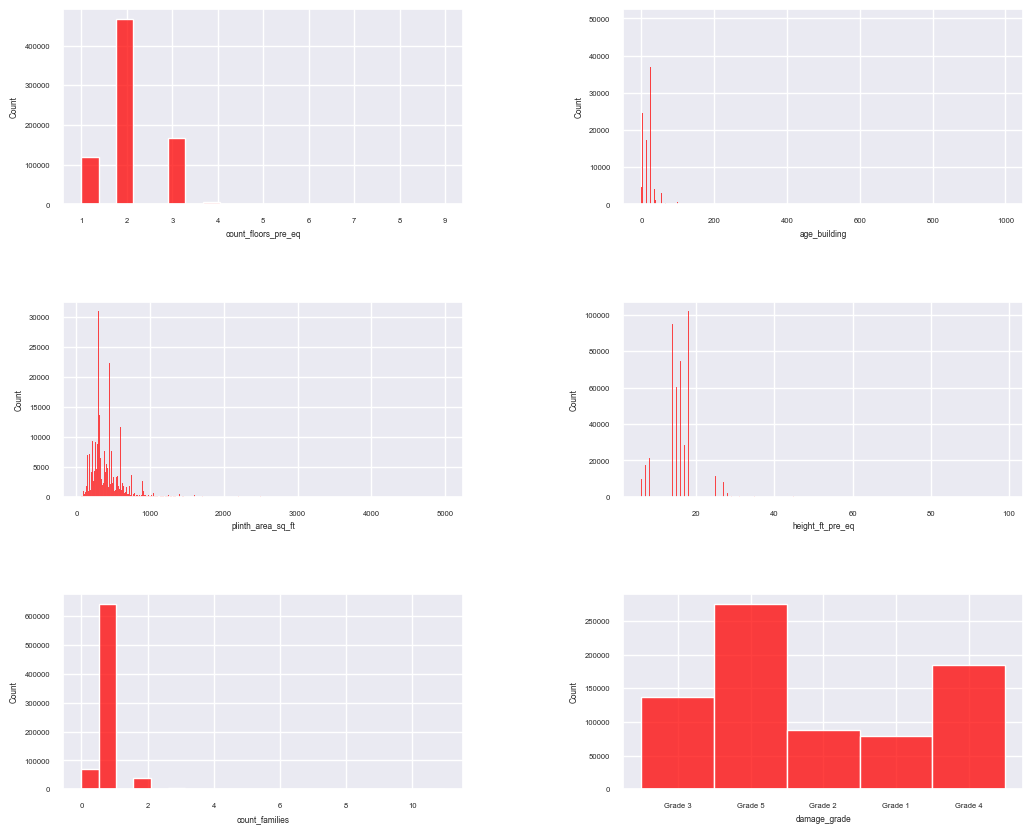

In [801]:
# Plot numeric histograms here

sns.set(font_scale=0.5)
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, top = 0.75)

sns.histplot(building_df['count_floors_pre_eq'], color="red", ax=axs[0, 0])
sns.histplot(building_df['age_building'], color="red", ax=axs[0, 1])
sns.histplot(building_df['plinth_area_sq_ft'], color="red", ax=axs[1, 0])
sns.histplot(building_df['height_ft_pre_eq'], color="red", ax=axs[1, 1])
sns.histplot(building_df['count_families'], color="red", ax=axs[2, 0])
sns.histplot(building_df['damage_grade'], color="red", ax=axs[2, 1])

plt.show()

#Plot Outliers

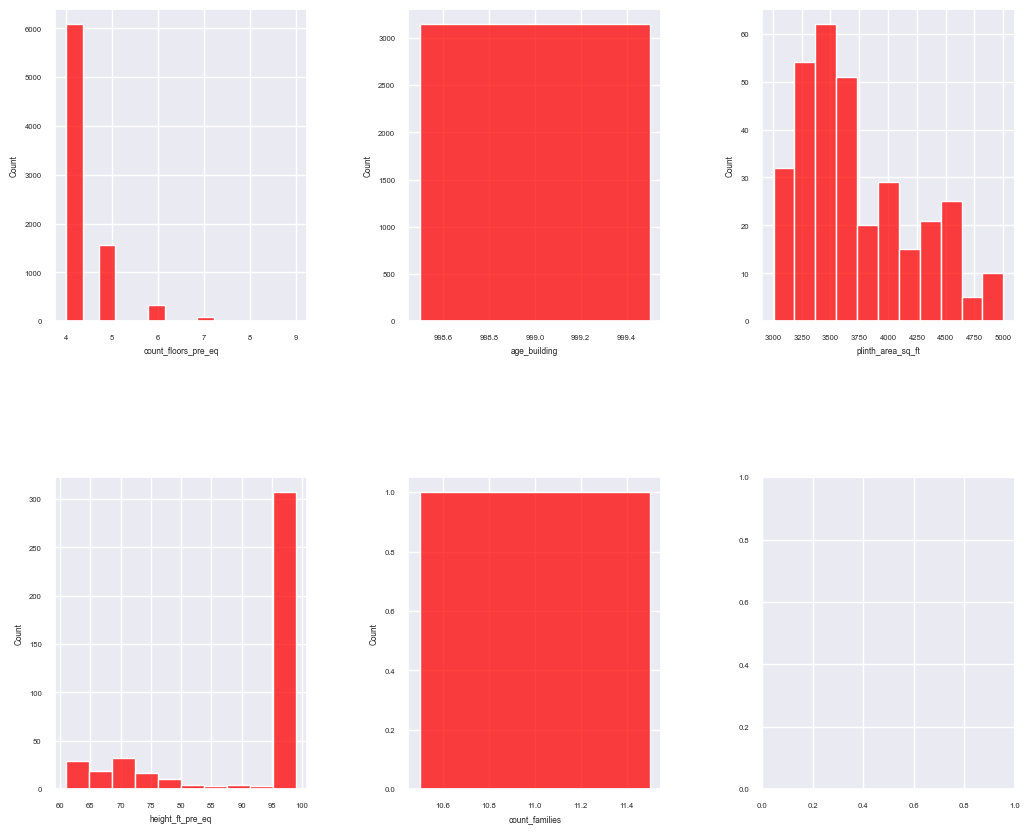

In [802]:
sns.set(font_scale=0.5)
fig, axs = plt.subplots(2, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, top = 0.75)

outfloor=building_df[building_df['count_floors_pre_eq']>3]
sns.histplot(outfloor['count_floors_pre_eq'], color="red", ax=axs[0, 0])

outage=building_df[building_df['age_building']>200]
sns.histplot(outage['age_building'], color="red", ax=axs[0, 1])

outplinth=building_df[building_df['plinth_area_sq_ft']>3000]
sns.histplot(outplinth['plinth_area_sq_ft'], color="red", ax=axs[0, 2])

outheight=building_df[building_df['height_ft_pre_eq']>60]
sns.histplot(outheight['height_ft_pre_eq'], color="red", ax=axs[1, 0])

outfam=building_df[building_df['count_families']>10]
sns.histplot(outfam['count_families'], color="red", ax=axs[1, 1])

plt.show()

#Investigate Building with Age = 999

In [803]:
print(outage)

        district_id  count_floors_pre_eq  age_building  plinth_area_sq_ft  height_ft_pre_eq land_surface_condition     foundation_type             roof_type         ground_floor_type  other_floor_type   ... has_secondary_use_use_police has_secondary_use_other  has_geotechnical_risk  has_geotechnical_risk_land_settlement  has_geotechnical_risk_fault_crack  has_geotechnical_risk_liquefaction  has_geotechnical_risk_landslide  has_geotechnical_risk_rock_fall  has_geotechnical_risk_flood  has_geotechnical_risk_other
2004        12                2                999             225                25                 Flat                    Bamboo/Timber  Bamboo/Timber-Light roof         Mud        TImber/Bamboo-Mud  ...               0                          0                    0.00                             0                                    0                                   0                                 0                                0                              0         

In [804]:
corr_df = building_df[['age_building', 'damage_grade']].corr()
#corr_df.rename(columns = lambda s: s[0:19], index = lambda s: s[0:19], inplace = True)
print(corr_df)

              age_building
age_building      1.00    


In [805]:
print(building_df.shape)
building_df.drop(building_df[building_df['age_building'] > 900].index, inplace = True)
building_df.shape

(762104, 45)


(758959, 45)

#Categorical Features

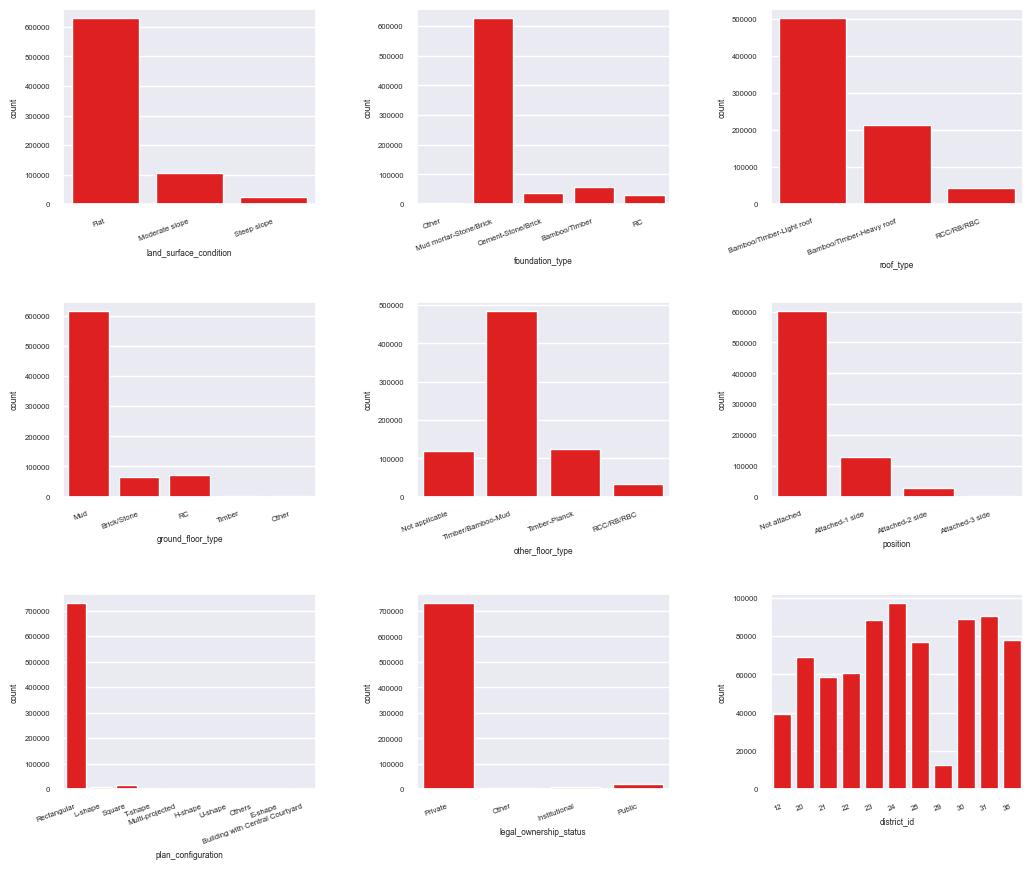

In [806]:
# Plot categorical histograms here

sns.set(font_scale=0.5)
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, top = 0.75)

chart = sns.countplot(x=building_df['land_surface_condition'], color="red", ax=axs[0, 0])
chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')
chart = sns.countplot(x=building_df['foundation_type'], color="red", ax=axs[0, 1])
chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')
chart = sns.countplot(x=building_df['roof_type'], color="red", ax=axs[0, 2])
chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')
chart = sns.countplot(x=building_df['ground_floor_type'], color="red", ax=axs[1, 0])
chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')
chart = sns.countplot(x=building_df['other_floor_type'], color="red", ax=axs[1, 1])
chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')
chart = sns.countplot(x=building_df['position'], color="red", ax=axs[1, 2])
chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')
chart = sns.countplot(x=building_df['plan_configuration'], color="red", ax=axs[2, 0])
chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')
chart = sns.countplot(x=building_df['legal_ownership_status'], color="red", ax=axs[2, 1])
chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')
chart = sns.countplot(x=building_df['district_id'], color="red", ax=axs[2, 2])
chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')

plt.show()

#Binary Features (Superstructure)

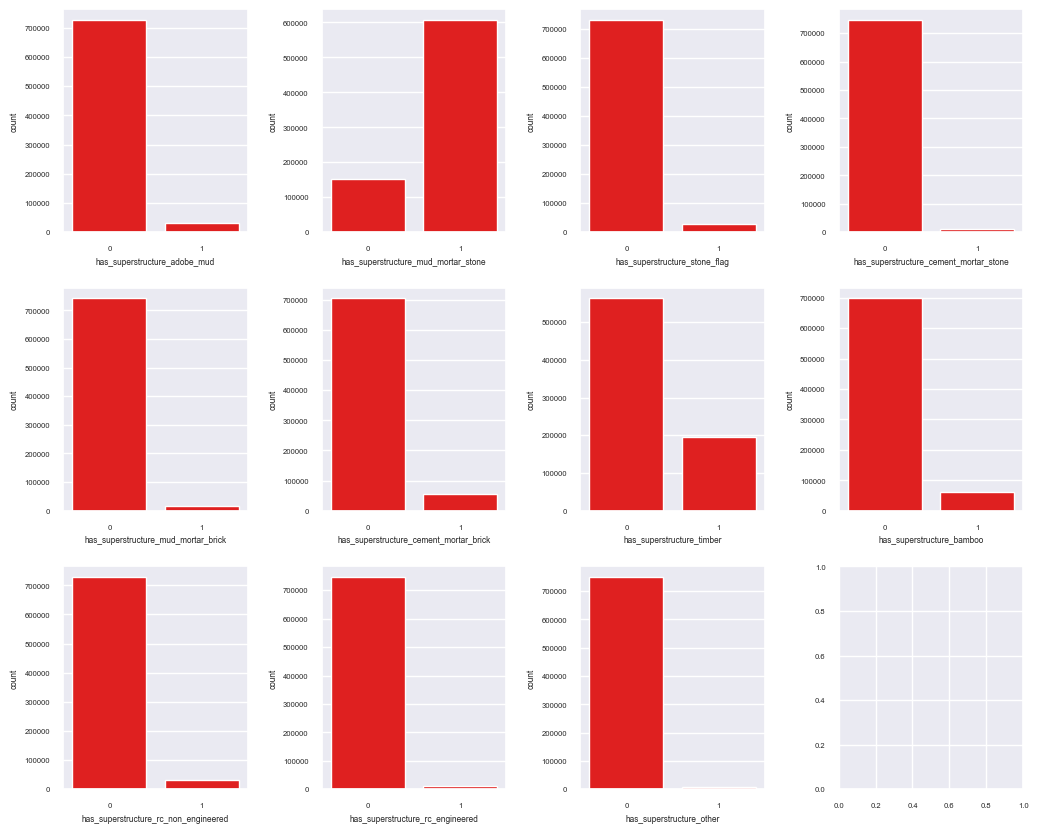

In [807]:
# Plot superstructure histograms here

sns.set(font_scale=0.5)
fig, axs = plt.subplots(3, 4, figsize=(12, 12))
fig.subplots_adjust(hspace=0.25, top = 0.75)

chart = sns.countplot(x=building_df['has_superstructure_adobe_mud'], color="red", ax=axs[0, 0])
chart = sns.countplot(x=building_df['has_superstructure_mud_mortar_stone'], color="red", ax=axs[0, 1])
chart = sns.countplot(x=building_df['has_superstructure_stone_flag'], color="red", ax=axs[0, 2])
chart = sns.countplot(x=building_df['has_superstructure_cement_mortar_stone'], color="red", ax=axs[0, 3])

chart = sns.countplot(x=building_df['has_superstructure_mud_mortar_brick'], color="red", ax=axs[1, 0])
chart = sns.countplot(x=building_df['has_superstructure_cement_mortar_brick'], color="red", ax=axs[1, 1])
chart = sns.countplot(x=building_df['has_superstructure_timber'], color="red", ax=axs[1, 2])
chart = sns.countplot(x=building_df['has_superstructure_bamboo'], color="red", ax=axs[1, 3])

chart = sns.countplot(x=building_df['has_superstructure_rc_non_engineered'], color="red", ax=axs[2, 0])
chart = sns.countplot(x=building_df['has_superstructure_rc_engineered'], color="red", ax=axs[2, 1])
chart = sns.countplot(x=building_df['has_superstructure_other'], color="red", ax=axs[2, 2])

plt.show()

#Binary Features (Secondary Use)

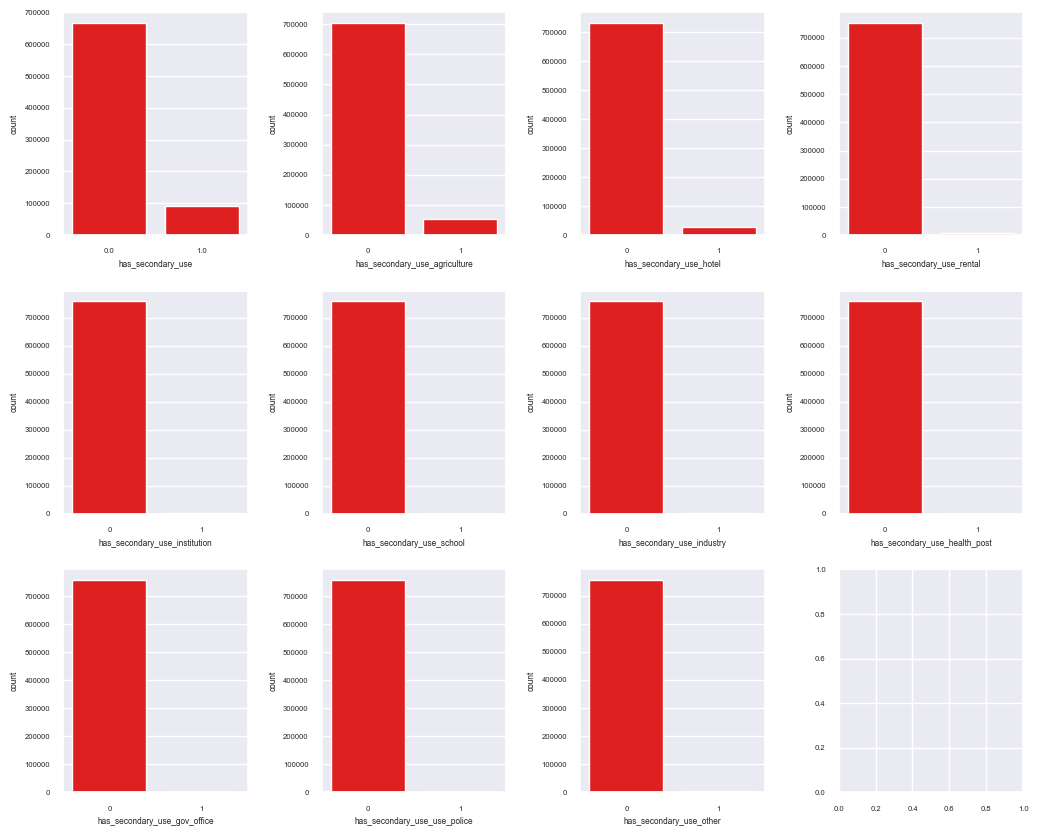

In [808]:
# Plot secondary use histograms here

sns.set(font_scale=0.5)
fig, axs = plt.subplots(3, 4, figsize=(12, 12))
fig.subplots_adjust(hspace=0.25, top = 0.75)

chart = sns.countplot(x=building_df['has_secondary_use'], color="red", ax=axs[0, 0])
chart = sns.countplot(x=building_df['has_secondary_use_agriculture'], color="red", ax=axs[0, 1])
chart = sns.countplot(x=building_df['has_secondary_use_hotel'], color="red", ax=axs[0, 2])
chart = sns.countplot(x=building_df['has_secondary_use_rental'], color="red", ax=axs[0, 3])

chart = sns.countplot(x=building_df['has_secondary_use_institution'], color="red", ax=axs[1, 0])
chart = sns.countplot(x=building_df['has_secondary_use_school'], color="red", ax=axs[1, 1])
chart = sns.countplot(x=building_df['has_secondary_use_industry'], color="red", ax=axs[1, 2])
chart = sns.countplot(x=building_df['has_secondary_use_health_post'], color="red", ax=axs[1, 3])

chart = sns.countplot(x=building_df['has_secondary_use_gov_office'], color="red", ax=axs[2, 0])
chart = sns.countplot(x=building_df['has_secondary_use_use_police'], color="red", ax=axs[2, 1])
chart = sns.countplot(x=building_df['has_secondary_use_other'], color="red", ax=axs[2, 2])

plt.show()

#Binary Features (Geotechnical Risk)

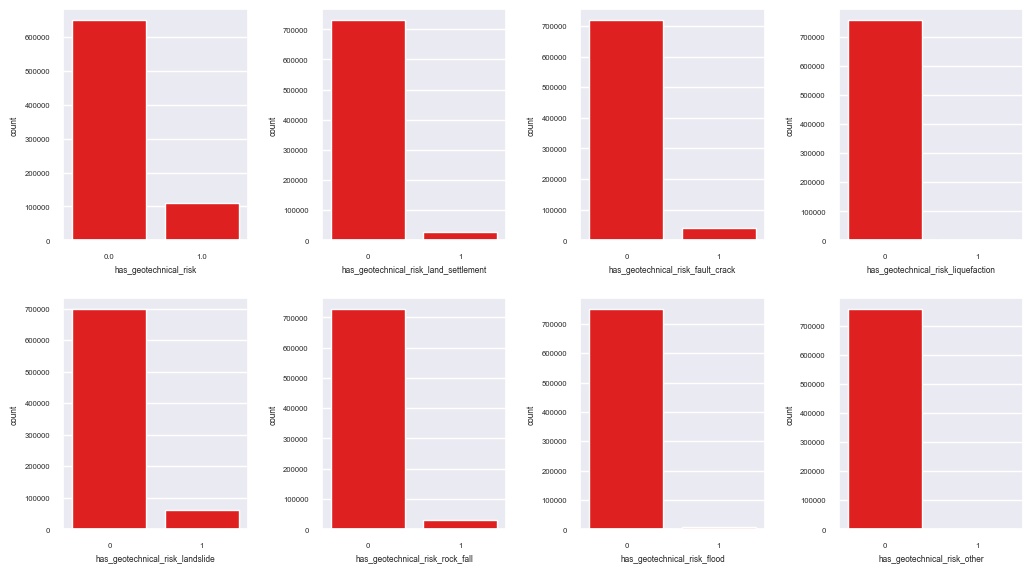

In [809]:
# Plot geotechnical risk histograms here

sns.set(font_scale=0.5)
fig, axs = plt.subplots(2, 4, figsize=(12, 8))
fig.subplots_adjust(hspace=0.25, top = 0.75)

chart = sns.countplot(x=building_df['has_geotechnical_risk'], color="red", ax=axs[0, 0])
chart = sns.countplot(x=building_df['has_geotechnical_risk_land_settlement'], color="red", ax=axs[0, 1])
chart = sns.countplot(x=building_df['has_geotechnical_risk_fault_crack'], color="red", ax=axs[0, 2])
chart = sns.countplot(x=building_df['has_geotechnical_risk_liquefaction'], color="red", ax=axs[0, 3])

chart = sns.countplot(x=building_df['has_geotechnical_risk_landslide'], color="red", ax=axs[1, 0])
chart = sns.countplot(x=building_df['has_geotechnical_risk_rock_fall'], color="red", ax=axs[1, 1])
chart = sns.countplot(x=building_df['has_geotechnical_risk_flood'], color="red", ax=axs[1, 2])
chart = sns.countplot(x=building_df['has_geotechnical_risk_other'], color="red", ax=axs[1, 3])

plt.show()

# Count building by district
## 11 districts suffered different damage

In [810]:
%%capture
'''
if binary_class:
  print(building_df.assign(Grade1_2_3= np.where(building_df['damage_grade']<0.5,1,0),
                     Grade4_5= np.where(building_df['damage_grade']>0.5,1,0),
                     Total=np.where(building_df['damage_grade']<0,0,1)).\
                     groupby('district_id',as_index=False).agg({'Grade1_2_3':sum,
                                                                'Grade4_5':sum,
                                                                'Total':sum}))
elif trinary_class:
  print(building_df.assign(Grade1_2_3= np.where(building_df['damage_grade']<0.5,1,0),
                     Grade4= np.where(building_df['damage_grade']==1,1,0),
                     Grade5= np.where(building_df['damage_grade']==2,1,0),
                     Total=np.where(building_df['damage_grade']<0,0,1)).\
                     groupby('district_id',as_index=False).agg({'Grade1_2_3':sum,
                                                                'Grade4':sum,
                                                                'Grade5':sum,
                                                                'Total':sum}))
elif quintary_class:
  print(building_df.assign(Grade1= np.where(building_df['damage_grade']==1,1,0),
                     Grade2= np.where(building_df['damage_grade']==2,1,0),
                     Grade3= np.where(building_df['damage_grade']==3,1,0),
                     Grade4= np.where(building_df['damage_grade']==4,1,0),
                     Grade5= np.where(building_df['damage_grade']==5,1,0),
                     Total=np.where(building_df['damage_grade']<0,0,1)).\
                     groupby('district_id',as_index=False).agg({'Grade1':sum,
                                                                'Grade2':sum,
                                                                'Grade3':sum,
                                                                'Grade4':sum,
                                                                'Grade5':sum,
                                                                'Total':sum}))
'''

##Use This Code Block to Select an Individual District (or Other Subgroup)

In [811]:
%%capture
'''
building_df = building_df[building_df['district_id']==12]
building_df.shape
building_df = building_df.drop(columns = ['district_id'])
building_df.shape
'''

#Set Target Name for Later Functions and Summarize Target

Target class (label) proportions:
Grade 5   36.19
Grade 4   24.13
Grade 3   17.89
Grade 2   11.45
Grade 1   10.34
NaN        0.00


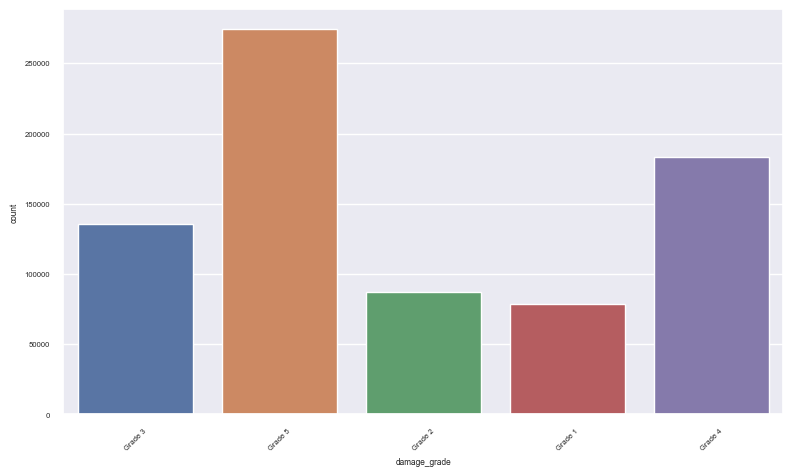

In [812]:
# Identify target (y)
target_col = 'damage_grade'

# Summarize target class balance
label_count = len(building_df)
label_props = (building_df.groupby(target_col, dropna = False)[target_col].count() / label_count * 100).sort_values(ascending = False)
print('Target class (label) proportions:'); print(label_props.to_string(header = False))

for field in ['damage_grade']:
  fig,ax = plt.subplots()
  sns.countplot(building_df[field])
  xticks = ax.get_yticklabels()
  ax.tick_params(axis = 'x', rotation = 45)

#Drop Small Number of Rows with Missing

In [813]:
# Drop (relatively immaterial number of) null labels
print('Starting rows:', len(building_df), end = ' ')

#building_df.dropna(axis = 0, subset = [target_col], inplace = True)
building_df.dropna(axis = 0, inplace = True)

print('Ending rows:', len(building_df))

#target_classes = sorted(building_df[target_col].unique())

Starting rows: 758959 Ending rows: 758947


# Use this Area to Drop Specific Features

In [814]:
#################### Edited to allow easy selection of features

# Identify prospective feature columns by 'type'
num_cols = [
    'count_floors_pre_eq',
    'age_building',
    'plinth_area_sq_ft',
    'height_ft_pre_eq',
    'count_families',
    ]                       #6         
cat_cols = [
    'land_surface_condition',
    'foundation_type',
    'roof_type',
    'ground_floor_type',
    'other_floor_type',
    'position',
    #'plan_configuration',         # NEAR ZERO VAR
    #'legal_ownership_status',         # NEAR ZERO VAR
    'district_id'
    ]                           #9
bin_cols = [
    'has_superstructure_adobe_mud',
    'has_superstructure_mud_mortar_stone',
    'has_superstructure_stone_flag',
    'has_superstructure_cement_mortar_stone',
    'has_superstructure_mud_mortar_brick',
    'has_superstructure_cement_mortar_brick',
    'has_superstructure_timber',
    'has_superstructure_bamboo',
    'has_superstructure_rc_non_engineered',
    'has_superstructure_rc_engineered',
    'has_superstructure_other',
    'has_secondary_use',
    #'has_secondary_use_agriculture',         # NEAR ZERO VAR
    #'has_secondary_use_hotel',         # NEAR ZERO VAR
    #'has_secondary_use_rental',         # NEAR ZERO VAR
    #'has_secondary_use_institution',         # NEAR ZERO VAR
    #'has_secondary_use_school',         # NEAR ZERO VAR
    #'has_secondary_use_industry',         # NEAR ZERO VAR
    #'has_secondary_use_health_post',         # NEAR ZERO VAR
    #'has_secondary_use_gov_office',         # NEAR ZERO VAR
    #'has_secondary_use_use_police',         # NEAR ZERO VAR
    #'has_secondary_use_other',          # NEAR ZERO VAR
    'has_geotechnical_risk',
    'has_geotechnical_risk_land_settlement',
    'has_geotechnical_risk_fault_crack',
    #'has_geotechnical_risk_liquefaction',         # NEAR ZERO VAR
    'has_geotechnical_risk_landslide',
    'has_geotechnical_risk_rock_fall',
    #'has_geotechnical_risk_flood',         # NEAR ZERO VAR
    #'has_geotechnical_risk_other'         # NEAR ZERO VAR
    ]                                   #30 (11, 11, 8 )

In [815]:
# Confirm [uniform] types
print(building_df.dtypes[num_cols].to_string())
print(building_df.dtypes[cat_cols].to_string())
print(building_df.dtypes[bin_cols].to_string())

count_floors_pre_eq      int64
age_building             int64
plinth_area_sq_ft        int64
height_ft_pre_eq         int64
count_families         float64
land_surface_condition    object
foundation_type           object
roof_type                 object
ground_floor_type         object
other_floor_type          object
position                  object
district_id                int64
has_superstructure_adobe_mud                int64
has_superstructure_mud_mortar_stone         int64
has_superstructure_stone_flag               int64
has_superstructure_cement_mortar_stone      int64
has_superstructure_mud_mortar_brick         int64
has_superstructure_cement_mortar_brick      int64
has_superstructure_timber                   int64
has_superstructure_bamboo                   int64
has_superstructure_rc_non_engineered        int64
has_superstructure_rc_engineered            int64
has_superstructure_other                    int64
has_secondary_use                         float64
has_geotechnic

# Merging only selected features (from lists above)

In [816]:
#################### New block that edits out columns with '#' in above block

building_df= pd.concat([building_df[num_cols], 
                        building_df[cat_cols],
                        building_df[bin_cols], 
                        building_df['damage_grade']], axis = 1)
building_df.head()

,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,count_families,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,...,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,has_secondary_use,has_geotechnical_risk,has_geotechnical_risk_land_settlement,has_geotechnical_risk_fault_crack,has_geotechnical_risk_landslide,has_geotechnical_risk_rock_fall,damage_grade
0,1,9,288,9,1.00,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,...,0,0,0,0.00,0.00,0,0,0,0,Grade 3
1,1,15,364,9,1.00,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,...,0,0,0,0.00,0.00,0,0,0,0,Grade 5
2,1,20,384,9,1.00,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,...,0,0,0,0.00,0.00,0,0,0,0,Grade 2
3,1,20,312,9,1.00,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,...,0,0,0,0.00,0.00,0,0,0,0,Grade 2
4,1,30,308,9,1.00,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,...,0,0,0,0.00,0.00,0,0,0,0,Grade 1


In [817]:
################# No longer need to name columns

# Update types as needed (for consistency)

building_df[num_cols] = building_df[num_cols].astype(int)
building_df[bin_cols] = building_df[bin_cols].astype(int)
#building_df['has_secondary_use'] = building_df['has_secondary_use'].astype(int)
#building_df['has_geotechnical_risk'] = building_df['has_geotechnical_risk'].astype(int)

In [818]:
# Confirm [uniform] types
print(building_df.dtypes[num_cols].to_string())
print(building_df.dtypes[cat_cols].to_string())
print(building_df.dtypes[bin_cols].to_string())

count_floors_pre_eq    int64
age_building           int64
plinth_area_sq_ft      int64
height_ft_pre_eq       int64
count_families         int64
land_surface_condition    object
foundation_type           object
roof_type                 object
ground_floor_type         object
other_floor_type          object
position                  object
district_id                int64
has_superstructure_adobe_mud              int64
has_superstructure_mud_mortar_stone       int64
has_superstructure_stone_flag             int64
has_superstructure_cement_mortar_stone    int64
has_superstructure_mud_mortar_brick       int64
has_superstructure_cement_mortar_brick    int64
has_superstructure_timber                 int64
has_superstructure_bamboo                 int64
has_superstructure_rc_non_engineered      int64
has_superstructure_rc_engineered          int64
has_superstructure_other                  int64
has_secondary_use                         int64
has_geotechnical_risk                     int64


In [819]:
building_df['district_id'] = building_df['district_id'].astype('object')

In [820]:
# Confirm [uniform] types
print(building_df.dtypes[num_cols].to_string())
print(building_df.dtypes[cat_cols].to_string())
print(building_df.dtypes[bin_cols].to_string())

count_floors_pre_eq    int64
age_building           int64
plinth_area_sq_ft      int64
height_ft_pre_eq       int64
count_families         int64
land_surface_condition    object
foundation_type           object
roof_type                 object
ground_floor_type         object
other_floor_type          object
position                  object
district_id               object
has_superstructure_adobe_mud              int64
has_superstructure_mud_mortar_stone       int64
has_superstructure_stone_flag             int64
has_superstructure_cement_mortar_stone    int64
has_superstructure_mud_mortar_brick       int64
has_superstructure_cement_mortar_brick    int64
has_superstructure_timber                 int64
has_superstructure_bamboo                 int64
has_superstructure_rc_non_engineered      int64
has_superstructure_rc_engineered          int64
has_superstructure_other                  int64
has_secondary_use                         int64
has_geotechnical_risk                     int64


In [821]:
%%capture
'''
# Update types as needed (for consistency)

building_df['count_families'] = building_df['count_families'].astype(int)
building_df['has_superstructure_other'] = building_df['has_superstructure_other'].astype(int)
building_df['has_secondary_use'] = building_df['has_secondary_use'].astype(int)
building_df['has_geotechnical_risk'] = building_df['has_geotechnical_risk'].astype(int)
'''

# Sample the full df to run model tests

In [823]:
building_df = building_df.sample(frac=.2, random_state=42)

#Remap the target before splitting

In [824]:
building_df.columns

Index(['count_floors_pre_eq', 'age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq', 'count_families', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'district_id', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 'has_secondary_use', 'has_geotechnical_risk', 'has_geotechnical_risk_land_settlement', 'has_geotechnical_risk_fault_crack', 'has_geotechnical_risk_landslide', 'has_geotechnical_risk_rock_fall', 'damage_grade'], dtype='object')

In [825]:
# Segregate data into predictor (X) and target (y) dataframes
building_X = building_df.loc[:, building_df.columns != 'damage_grade'].copy()
building_y = building_df['damage_grade']

# Partition data 70/30, stratifying for class balance (ref. above)
X_train, X_test, y_train, y_test = train_test_split(
    building_X, building_y, test_size = 0.3, random_state = 42, stratify = building_y
)

In [826]:
building_y.head()

77543     Grade 3
46583     Grade 3
442676    Grade 4
326571    Grade 3
457269    Grade 4
Name: damage_grade, dtype: object

In [827]:
na_df = pd.DataFrame(X_train[num_cols + cat_cols + bin_cols].isna().sum()) / len(X_train) * 100
na_df.index.name = 'column'; na_df.reset_index(inplace = True)
print('Proportion of nulls:'); print(na_df[na_df[0] > 0].to_string(index = False, header = False))

Proportion of nulls:
Empty DataFrame
Columns: [column, 0]
Index: []


In [828]:
%%capture
# Address missing/null values here? Or, pipeline? For both train, test. . .

############## Eliminated
'''
X_train['damage_overall_collapse'].fillna('[missing]', inplace = True)
X_test['damage_overall_collapse'].fillna('[missing]', inplace = True)

X_train['damage_overall_leaning'].fillna('[missing]', inplace = True)
X_test['damage_overall_leaning'].fillna('[missing]', inplace = True)
'''

In [829]:
cat_count = len(X_train)
for cc in cat_cols:
    print()
    print(cc, '-')
    for cv in pd.unique(X_train[cc]):
        if isinstance(cv, float) != True:
            print(cv, '(%.2f)' % (X_train[X_train[cc] == cv][cc].count() / cat_count * 100))


land_surface_condition -
Steep slope (3.29)
Flat (82.76)
Moderate slope (13.95)

foundation_type -
Mud mortar-Stone/Brick (82.34)
Bamboo/Timber (7.59)
Cement-Stone/Brick (5.22)
RC (4.25)
Other (0.61)

roof_type -
Bamboo/Timber-Heavy roof (28.18)
Bamboo/Timber-Light roof (65.97)
RCC/RB/RBC (5.85)

ground_floor_type -
Mud (81.06)
RC (9.55)
Brick/Stone (8.77)
Timber (0.48)
Other (0.13)

other_floor_type -
Timber-Planck (16.12)
TImber/Bamboo-Mud (64.02)
Not applicable (15.53)
RCC/RB/RBC (4.34)

position -
Not attached (79.06)
Attached-1 side (17.19)
Attached-2 side (3.57)
Attached-3 side (0.18)

district_id -
20 (9.08)
36 (10.24)
28 (10.34)
31 (11.88)
22 (7.92)
30 (11.70)
23 (11.61)
21 (7.73)
12 (5.17)
24 (12.66)
29 (1.66)


In [830]:
# Encode categorical label (y)
target_classes = sorted(building_df[target_col].unique())
label_enc = LabelEncoder().fit(y_train)
y_train = label_enc.transform(y_train)
y_test = label_enc.transform(y_test)

In [831]:
print('Skewness:'); print(pd.DataFrame(building_X[num_cols].skew()).to_string(header = False))

Skewness:
count_floors_pre_eq 0.40
age_building        2.22
plinth_area_sq_ft   3.78
height_ft_pre_eq    2.49
count_families      1.54


In [832]:
print(building_X[bin_cols].max() - building_X[bin_cols].min())

has_superstructure_adobe_mud              1
has_superstructure_mud_mortar_stone       1
has_superstructure_stone_flag             1
has_superstructure_cement_mortar_stone    1
has_superstructure_mud_mortar_brick       1
has_superstructure_cement_mortar_brick    1
has_superstructure_timber                 1
has_superstructure_bamboo                 1
has_superstructure_rc_non_engineered      1
has_superstructure_rc_engineered          1
has_superstructure_other                  1
has_secondary_use                         1
has_geotechnical_risk                     1
has_geotechnical_risk_land_settlement     1
has_geotechnical_risk_fault_crack         1
has_geotechnical_risk_landslide           1
has_geotechnical_risk_rock_fall           1
dtype: int64


In [833]:
corr_df = X_train[num_cols].corr()
corr_df.rename(columns = lambda s: s[0:19], index = lambda s: s[0:19], inplace = True)
print(corr_df)

                     count_floors_pre_eq  age_building  plinth_area_sq_ft  height_ft_pre_eq  count_families
count_floors_pre_eq         1.00              0.18            0.10               0.71             0.09     
age_building                0.18              1.00           -0.05               0.11             0.03     
plinth_area_sq_ft           0.10             -0.05            1.00               0.21             0.11     
height_ft_pre_eq            0.71              0.11            0.21               1.00             0.07     
count_families              0.09              0.03            0.11               0.07             1.00     


# Modeling - Build, Execute, Evaluation Iterations

In [834]:
# Standardized modeling function, to create and execute a modeling pipeline through
#   to model performance metrics
def model(algorithm, iteration, params,
          classes, X_tr, y_tr, X_te, y_te, 
          cv = 0, plot_cm = False, plot_auc = False):

    # Create transformers
    cat_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
    standardizer = StandardScaler()
    
    # Create preprocessor
    cat_transformer = make_pipeline(cat_encoder)
    num_transformer = make_pipeline(standardizer)
    preprocessor = ColumnTransformer(
        [('cat', cat_transformer, cat_cols),
         ('num', num_transformer, num_cols)]
    )

    # Prepare algorithm with hyperparameters+
    algorithm.set_params(**params)
    algorithm_name = type(algorithm).__name__ + ' (' + str(iteration) + ')'
    
    # Create pipeline and cross-validate model (for later output)
    pipe = make_pipeline(preprocessor, algorithm)
    
    # Fit model
    print('\n\n')
    print('Fitting ' + algorithm_name + '...', end = ' ')
    fit_start = time()
    pipe.fit(X_tr, y_tr)
    fit_time = time() - fit_start
    print('done in %0.3fs.' % fit_time)
    
    # Cross-validate model
    scores = []
    cv_time = 0
    if (cv > 0):
        print('Cross-validating ' + algorithm_name + '...', end = ' ')
        cv_start = time()
        scores = cross_val_score(pipe, X_tr, y_tr, cv = cv, scoring = 'accuracy')
        cv_time = time() - cv_start
        print('done in %0.3fs.' % cv_time)
        print(scores)
    
    # Validate model
    print('Validating ' + algorithm_name + '...', end = ' ')
    val_start = time()
    y_tr_pred = pipe.predict(X_tr)
    y_te_pred = pipe.predict(X_te)
    val_time = time() - val_start
    print('done in %0.2fs.' % val_time)

    # Show validation results
    if plot_cm:
        ConfusionMatrixDisplay.from_predictions(y_te, y_te_pred,
#                                                display_labels = classes,
                                                cmap = 'Purples')
        plt.suptitle(algorithm_name, y = 1)
        plt.title(params)
        plt.show()

    print('\n', algorithm_name)
    print(params)
    print(classification_report(y_te, y_te_pred))
        
    # calculate AUC and persist, Show ROC AUC results
    roc_auc = None
    if plot_auc:
      fpr, tpr, threshold = roc_curve(y_te, y_te_pred)
      roc_auc = auc(fpr, tpr)

      figure(figsize = [3,2])
      plt.title('Receiver Operating Characteristic')
      plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

      plt.legend(loc = 'lower right')
      plt.plot([0, 1], [0, 1],'r--')
      plt.xlim([0, 1])
      plt.ylim([0, 1])
      plt.ylabel('True Positive Rate')
      plt.xlabel('False Positive Rate')
      plt.show()
    
    # Persist pipeline (+model)
    pipe_filename = algorithm_name + '.pipe'
    joblib.dump(pipe, pipe_filename)
    
    # Persist results
    results = []
    results.append ({
        'algorithm': algorithm_name,
        'parameters': params,
        'fit_time': fit_time,
        'cv_time': cv_time,
        'val_time': val_time,
        'scores': tuple(scores),
        'train_acc': accuracy_score(y_tr_pred, y_tr),
        'test_acc': accuracy_score(y_te_pred, y_te),
        'roc_auc': roc_auc
    })
    results_filename = algorithm_name + '.results'
    joblib.dump(results, results_filename)

    return pd.DataFrame(results)

In [835]:
# Leveraging the following function code from a Web source; full attribution to link below
#   This function enables efficient np.array update when we're going from [default] multiclass
#   to experimental binomial classification
#   https://stackoverflow.com/questions/47171356/replace-values-in-numpy-array-based-on-dictionary-and-avoid-overlap-between-new
    
def replace_with_dict(ar, dic):
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()
    
    # Drop the magic bomb with searchsorted to get the corresponding
    # places for a in keys (using sorter since a is not necessarily sorted).
    # Then trace it back to original order with indexing into sidx
    # Finally index into values for desired output.
    return v[sidx[np.searchsorted(k,ar,sorter=sidx)]]

In [836]:
# Setup for modeling
y_train_hold = y_train
y_test_hold = y_test
bin_label_dict = {0: 0, 1: 0, 2: 0, 3: 1, 4: 1}

In [837]:
clf_results = pd.DataFrame()




Fitting LogisticRegression (multinomial)... done in 5.259s.
Cross-validating LogisticRegression (multinomial)... done in 23.552s.
[0.47 0.47 0.47 0.47 0.46]
Validating LogisticRegression (multinomial)... done in 0.17s.


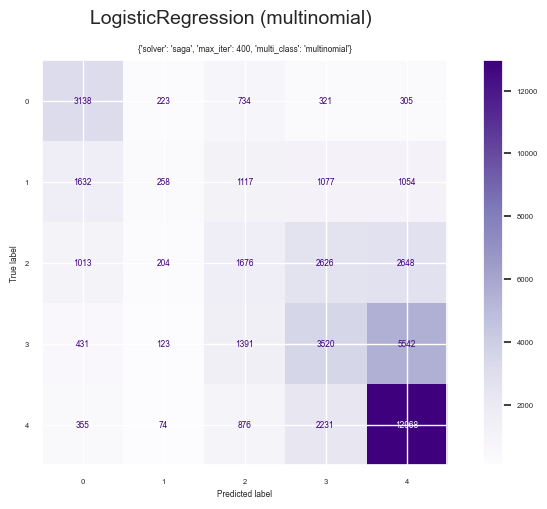


 LogisticRegression (multinomial)
{'solver': 'saga', 'max_iter': 400, 'multi_class': 'multinomial'}
              precision    recall  f1-score   support

           0       0.48      0.66      0.56      4721
           1       0.29      0.05      0.09      5138
           2       0.29      0.21      0.24      8167
           3       0.36      0.32      0.34     11007
           4       0.58      0.79      0.66     16504

    accuracy                           0.47     45537
   macro avg       0.40      0.41      0.38     45537
weighted avg       0.43      0.47      0.43     45537




Fitting LogisticRegression (binomial)... done in 1.755s.
Cross-validating LogisticRegression (binomial)... done in 8.851s.
[0.76 0.76 0.76 0.76 0.76]
Validating LogisticRegression (binomial)... done in 0.15s.


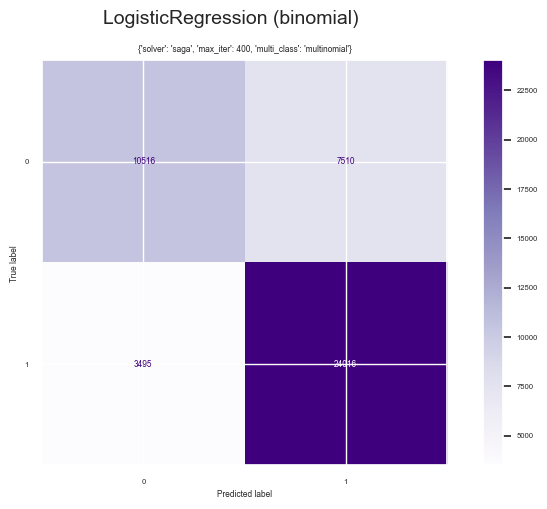


 LogisticRegression (binomial)
{'solver': 'saga', 'max_iter': 400, 'multi_class': 'multinomial'}
              precision    recall  f1-score   support

           0       0.75      0.58      0.66     18026
           1       0.76      0.87      0.81     27511

    accuracy                           0.76     45537
   macro avg       0.76      0.73      0.74     45537
weighted avg       0.76      0.76      0.75     45537




Fitting DecisionTreeClassifier (multinomial:5)... done in 0.250s.
Validating DecisionTreeClassifier (multinomial:5)... done in 0.15s.

 DecisionTreeClassifier (multinomial:5)
{'max_depth': 5}
              precision    recall  f1-score   support

           0       0.41      0.77      0.53      4721
           1       0.27      0.03      0.06      5138
           2       0.27      0.10      0.14      8167
           3       0.31      0.02      0.03     11007
           4       0.47      0.92      0.62     16504

    accuracy                           0.44     45537





Fitting Perceptron (binomial)... done in 0.301s.
Validating Perceptron (binomial)... done in 0.16s.

 Perceptron (binomial)
{'class_weight': 'balanced'}
              precision    recall  f1-score   support

           0       0.68      0.48      0.56     18026
           1       0.71      0.85      0.78     27511

    accuracy                           0.70     45537
   macro avg       0.70      0.66      0.67     45537
weighted avg       0.70      0.70      0.69     45537




Fitting LinearSVC (multinomial)... done in 28.446s.
Validating LinearSVC (multinomial)... done in 0.16s.

 LinearSVC (multinomial)
{'multi_class': 'crammer_singer', 'max_iter': 2000}
              precision    recall  f1-score   support

           0       0.48      0.60      0.53      4721
           1       0.14      0.45      0.22      5138
           2       0.21      0.02      0.04      8167
           3       0.28      0.06      0.10     11007
           4       0.58      0.71      0.64     16504

    a

Validating BernoulliNB (binomial:5)... done in 0.20s.

 BernoulliNB (binomial:5)
{'alpha': 5}
              precision    recall  f1-score   support

           0       0.74      0.50      0.60     18026
           1       0.73      0.89      0.80     27511

    accuracy                           0.73     45537
   macro avg       0.74      0.69      0.70     45537
weighted avg       0.74      0.73      0.72     45537




Fitting BernoulliNB (multinomial:10)... done in 0.170s.
Validating BernoulliNB (multinomial:10)... done in 0.19s.

 BernoulliNB (multinomial:10)
{'alpha': 10}
              precision    recall  f1-score   support

           0       0.48      0.60      0.54      4721
           1       0.22      0.11      0.14      5138
           2       0.26      0.15      0.19      8167
           3       0.34      0.35      0.35     11007
           4       0.59      0.75      0.66     16504

    accuracy                           0.46     45537
   macro avg       0.38      0.39    

In [838]:
def reset_target(binomial):
    global y_train, y_test
    y_train = y_train_hold
    y_test = y_test_hold
    if binomial:
        y_train = replace_with_dict(y_train, bin_label_dict)
        y_test = replace_with_dict(y_test, bin_label_dict)

def i_desc(v, binomial):
    desc = 'binomial' if binomial else 'multinomial'
    if v > 0: desc += ':' + str(v)
    return desc

# Logistic Regression (baseline)
for i in range(1, 3):
    reset_target(i == 2)
    logr_r = model(LogisticRegression(),
                   i_desc(0, i == 2),
                   {'solver': 'saga', 'max_iter': 400, 'multi_class': 'multinomial'},
                   target_classes, X_train, y_train, X_test, y_test,
                   cv = 5, plot_cm = True, plot_auc = False)
    clf_results = pd.concat([clf_results, logr_r])
    
# Decision Trees
for depth in range(5, 11):
    for i in range(1, 3):
        reset_target(i == 2)
        tree_r = model(DecisionTreeClassifier(),
                       i_desc(depth, i == 2),
                       {'max_depth': depth},
                       target_classes, X_train, y_train, X_test, y_test,
                       cv = 0, plot_cm = False, plot_auc = False)
        clf_results = pd.concat([clf_results, tree_r])

# Perceptron
for i in range(1, 3):
    reset_target(i == 2)
    perc_r = model(Perceptron(),
                   i_desc(0, i == 2),
                   {'class_weight': 'balanced'},
                   target_classes, X_train, y_train, X_test, y_test,
                   cv = 0, plot_cm = False, plot_auc = False)
    clf_results = pd.concat([clf_results, perc_r])

# Support Vector Machine
for i in range(1, 3):
    reset_target(i == 2)
    svm_r = model(LinearSVC(), 
                  i_desc(0, i == 2),
                  {'multi_class': 'crammer_singer', 'max_iter': 2000},
                  target_classes, X_train, y_train, X_test, y_test,
                  cv = 0, plot_cm = False, plot_auc = False)
    clf_results = pd.concat([clf_results, svm_r])
    
# Neural Network
for i in range(1, 3):
    reset_target(i == 2)
    nn_r = model(MLPClassifier(),
                 i_desc(0, i == 2),
                 {'random_state' : 1, 'max_iter': 500},
                 target_classes, X_train, y_train, X_test, y_test,
                 cv = 0, plot_cm = False, plot_auc = False)
    clf_results = pd.concat([clf_results, nn_r])

# Random Forest    
for i in range(1, 3):
    reset_target(i == 2)
    rf_r = model(RandomForestClassifier(),
                 i_desc(0, i == 2),
                 {'max_depth' : 5},
                 target_classes, X_train, y_train, X_test, y_test,
                 cv = 0, plot_cm = False, plot_auc = False)
    clf_results = pd.concat([clf_results, rf_r])
    
# Ridge Classifier
for i in range(1, 3):
    reset_target(i == 2)
    ridge_r = model(RidgeClassifier(),
                 i_desc(0, i == 2),
                 {'alpha' : 1, 'max_iter': 1000},
                 target_classes, X_train, y_train, X_test, y_test,
                 cv = 0, plot_cm = False, plot_auc = False)
    clf_results = pd.concat([clf_results, ridge_r])
    
# Naive Bayes
alpha = [0.1, 1, 5, 10]
for a in range(0, len(alpha)):
    for i in range(1, 3):
        reset_target(i == 2)
        nbbern_r = model(BernoulliNB(),
                         i_desc(alpha[a], i == 2),
                         {'alpha' : alpha[a]},
                         target_classes, X_train, y_train, X_test, y_test,
                         cv = 0, plot_cm = False, plot_auc = False)
        clf_results = pd.concat([clf_results, nbbern_r])    

In [839]:
clf_results

,algorithm,parameters,fit_time,cv_time,val_time,scores,train_acc,test_acc,roc_auc
0,LogisticRegression (multinomial),"{'solver': 'saga', 'max_iter': 400, 'multi_cla...",5.26,23.55,0.17,"(0.4721660157169074, 0.47178956284410145, 0.46...",0.47,0.47,None
0,LogisticRegression (binomial),"{'solver': 'saga', 'max_iter': 400, 'multi_cla...",1.75,8.85,0.15,"(0.757799632958449, 0.7593525010587737, 0.7552...",0.76,0.76,None
0,DecisionTreeClassifier (multinomial:5),{'max_depth': 5},0.25,0.00,0.15,(),0.44,0.44,None
0,DecisionTreeClassifier (binomial:5),{'max_depth': 5},0.25,0.00,0.15,(),0.75,0.75,None
0,DecisionTreeClassifier (multinomial:6),{'max_depth': 6},0.28,0.00,0.16,(),0.44,0.44,None
0,DecisionTreeClassifier (binomial:6),{'max_depth': 6},0.28,0.00,0.16,(),0.75,0.75,None
0,DecisionTreeClassifier (multinomial:7),{'max_depth': 7},0.29,0.00,0.16,(),0.45,0.45,None
0,DecisionTreeClassifier (binomial:7),{'max_depth': 7},0.30,0.00,0.16,(),0.75,0.75,None
0,DecisionTreeClassifier (multinomial:8),{'max_depth': 8},0.31,0.00,0.16,(),0.47,0.47,None
0,DecisionTreeClassifier (binomial:8),{'max_depth': 8},0.31,0.00,0.16,(),0.76,0.75,None


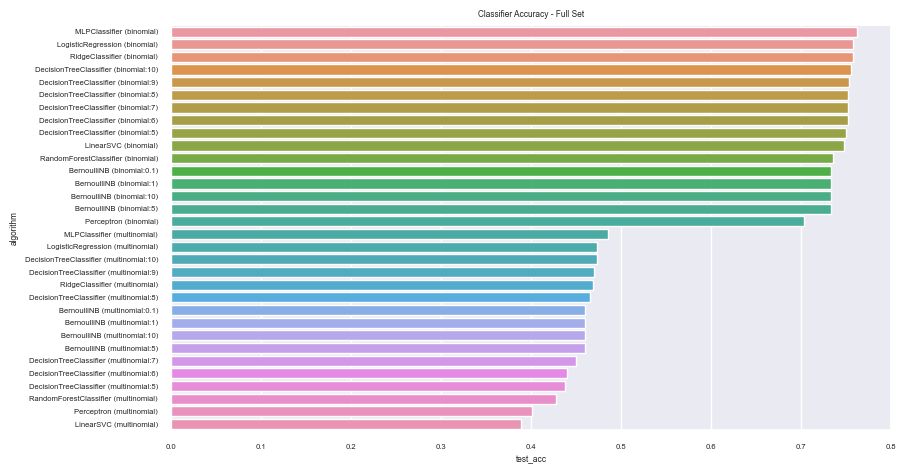

In [841]:
clf_comp = clf_results
clf_comp.sort_values(by = ['test_acc'], inplace = True, ascending = False)
fix, ax = plt.subplots()
sns.barplot(x = 'test_acc', y = 'algorithm', data = clf_comp)
plt.title('Classifier Accuracy - Full Set')
plt.show()